# **HW4: Machine Learning Based Investment Strategy For NBA Players Memorabilia**

## **BAX 357 - Predictive Analytics**

## **For this project, I will use real data on past basketball players and machine learning techniques to make informed memorabilia investment decisions! To begin, I will import the following libraries and read in the dataframe below.**

In [1]:
# Import Libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split

# Reset Plot Settings
plt.rcdefaults()

In [2]:
NBA_Data = pd.read_csv('NBA_Data.csv',index_col=0)

## **About the data:**

You are provided with data on past players that includes 27 different predictors/attributes on each player. The complete list is as follows:

Field | Description
------|------------
games|games played
minutes|minutes played
pts|points
offReb|offensive rebounds
defReb|defensive rebounds
reb|rebounds
asts|assists
stl|steals* (see below)
blk|blocks* (see below)
turnover|turnovers* (see below)
pf|Personal Fouls
fga|field goals attempted
fgm|field goals made
fta|free throws attempted
ftm|free throws made
tpa|three pointers attempted* (see below)
tpm|three pointers made* (see below)
totalSeasons|Total number of seasons played. This value is calculated as follows: "lastSeason - firstSeason + 1"
firstSeason|First season played. The year corresponds to the first year of the season (i.e. a value of 2000 represents the 2000-2001 season).
lastSeason|Last season played. The year corresponds to the first year of the season (i.e. a value of 2000 represents the 2000-2001 season). Note that 2004 (2004-2005 season) is the last year for which there is data.
careerEnded|Boolean field for if the player's career has ended (1 if career has ended, 0 otherwise). This field was calculated as follows: if the "lastSeason" field is earlier than 2004, the value is 1, otherwise 0. Note that this calculation naively assumes that no players retired at the end of the 2004  season.
yrsRetired2004|The number of seasons that a player has been retired as of the 2004-2005 season.
class|A Boolean field showing whether or not a player was inducted to the Basketball Hall of Fame (HoF) as a player. This field has value 1 if the player has been inducted, and 0 otherwise.
league| N = National Basketball Association (NBA); A = American Basketball Association (ABA)
position|C = Center; F = Forward; G = Guard

Important Notes:

* The NBA did not have three point shots until 1979.
* Steals, Blocks and Turnovers were not recorded in the NBA until 1973.

Each row corresponds to a player and contains the player's attributes above.

The first 5 rows of the dataframe are shown below:

In [3]:
NBA_Data.head()

,games,minutes,pts,offReb,defReb,reb,asts,stl,blk,turnover,...,firstSeason,lastSeason,careerEnded,yrsRetired2004,class,league_A,league_N,Position_C,Position_F,Position_G
0,408.0,9825.0,5232.0,476.0,824.0,1300.0,866.0,265.0,175.0,700.0,...,1982.0,1990.0,1.0,14.0,False,0,1,0,0,1
1,51.0,0.0,587.0,0.0,0.0,0.0,158.0,0.0,0.0,0.0,...,1949.0,1949.0,1.0,55.0,False,0,1,0,0,1
2,265.0,0.0,1712.0,0.0,0.0,72.0,311.0,0.0,0.0,0.0,...,1946.0,1950.0,1.0,54.0,False,0,1,0,0,1
3,133.0,2587.0,992.0,55.0,198.0,253.0,291.0,123.0,14.0,207.0,...,2003.0,2004.0,0.0,0.0,False,0,1,0,0,1
4,8.0,28.0,7.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,...,2004.0,2004.0,0.0,0.0,False,0,1,0,0,1


**My task is to use this historical dataset to build a classification model predicting whether or not a given player will be inducted into the NBA Hall of Fame (and the probability thereof). Once I build your model, I will then apply it to select players to invest in.**

The goal of this project is to develop hands-on experience in developing and evaluating different machine learning models to inform interventions (in this case, investment decisions) and to maximize profitability (**wherein each time you correctly predict that a player will be inducted into the hall of fame, you turn a profit, and every other player captured is considered a loss**). This will be explained in greater detail in Part III of the project.

The data set includes a target variable (i.e., the class) which indicates whether or not the player has been inducted to the hall of fame. The target variable is binary and has value 1 if the player has been inducted or 0 otherwise.

Important Notes:

* We assume that a player who has not been inducted 45.4 years after retirement, will not be inducted.
* The data includes the actual target variable value for each player. This information is available for this assignment in order to allow you to evaluate the efficacy of investment decisions and to compare amongst investments selected by different models to identify the best model to use in the future. However, in actual deployment, we would not have access to this target variable.

## **Part I: Building, Evaluating and Comparing Different Machine Learning Models**

**1.1: For the purposes of this project, I will create and fit a [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html), and [KNeighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to the data. I will compare the results of my models using 10-Fold Cross Validation and display the results here for each model. I will also play with the parameters for each model to try and generate better results while keeping in mind best practices to avoid overfitting. (5 Points)**

My goal is to optimize for model accuracy and area under the ROC (use [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)); do not worry about profitability at this stage.  

Additionally, make sure to split your data into a train and test dataset with the [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method. Consider the training data as historical data that you were provided with to develop an investment strategy. The test set includes players, the memorabilia of which you are considering to invest in.

**Additionally, I will set the `test_size = 0.33`.**

In [4]:
X = NBA_Data.drop(columns='class')
y = NBA_Data['class']
X = np.ascontiguousarray(X)


X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.33, random_state=3) # Fill in Code Here



# Insert Remaining Code Here

# Report Score Function
def report_score(mymodel, X, y, mycv):
# To use this function, all we need to do is feed it our model of interest, X, y, and the number of folds for cross-validation.

    # Calculate and print the cross-validation accuracy
    cross_val_accuracy = round(cross_val_score(mymodel, X, y, cv = mycv).mean()*100,2)
    print(f"{mycv}-Fold Cross-Validation Classification Accuracy: {cross_val_accuracy:.2f}%")

    # Calculate and print the cross-validation ROC AUC
    cross_val_accuracy_roc_auc = round(cross_val_score(mymodel, X, y, cv =  mycv, scoring = 'roc_auc').mean()*100,2)
    print(f"\n{mycv}-Fold Cross-Validation ROC AUC: {cross_val_accuracy_roc_auc:.2f} %")

    # Decision Tree Model
decisions = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state = 3).fit(X_training, y_training)

#Bagging Model
bagging_model = BaggingClassifier(n_estimators = 30, random_state = 3).fit(X_training, y_training)

#Random Forest
randomforestog = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, random_state = 3).fit(X_training,y_training)

#Multinomial Naive Bayes Model
bayes = MultinomialNB().fit(X_training,y_training)

#knn
knn = KNeighborsClassifier(n_neighbors=3).fit(X_training,y_training)



In [5]:
print('Decision Tree Classifier:')
report_score(decisions, X_training, y_training, 10)

print('\n-----------------------------------------------------\n')

print('Bagging Model')
report_score(bagging_model,X_training, y_training,10)

print('\n-----------------------------------------------------\n')

print('Random Forest Model')
report_score(randomforestog,X_training, y_training,10)

print('\n-----------------------------------------------------\n')

print('Multinomial Naive Bayes Model')
report_score(bayes, X_training, y_training,10)

print('\n-----------------------------------------------------\n')

print('KNeighbors Classifier')
report_score(knn, X_training, y_training,10)

Decision Tree Classifier:
10-Fold Cross-Validation Classification Accuracy: 97.29%

10-Fold Cross-Validation ROC AUC: 91.69 %

-----------------------------------------------------

Bagging Model


10-Fold Cross-Validation Classification Accuracy: 96.37%

10-Fold Cross-Validation ROC AUC: 97.52 %

-----------------------------------------------------

Random Forest Model
10-Fold Cross-Validation Classification Accuracy: 98.49%

10-Fold Cross-Validation ROC AUC: 97.89 %

-----------------------------------------------------

Multinomial Naive Bayes Model
10-Fold Cross-Validation Classification Accuracy: 88.25%

10-Fold Cross-Validation ROC AUC: 92.15 %

-----------------------------------------------------

KNeighbors Classifier
10-Fold Cross-Validation Classification Accuracy: 97.89%

10-Fold Cross-Validation ROC AUC: 88.68 %


**1.2: Using classification accuracy rate as the evaluation measure, which model best predicts whether or not a player will be inducted?**


        The random forest model best predicts whether or not a player will be inducted based on classification accuracy.

**1.3: Using the area under the ROC, which model yields the largest area under the ROC?**

        The random forest model yields the largest area under the ROC

**1.4: Given your goal is to identify and invest in a set of players likely to be inducted to the Hall of Fame, which of the two measures above (classification accuracy rate or ROC area) is more appropriate for selecting the model to inform your investments? Explain your answer.**

Note that while classification accuracy rate and ROC area may often agree, in some cases the classification accuracy of two models may be comparable, while the ROC area of one may be larger than the other.

        The ROC area is more appropriate for selecting the model to inform my investments because it has the ability to distinguish between two classes (yes or no Hall of Fame in this homework). Moreover, the ROC AUC allows us to make threshholds when classifying whether or not someone made the Hall of Fame after we create our mode. This will allow us to create a model that will provide the highest profit based on a probability threshhold we will set.

## **Part II: Analysis and Model Improvement**

**2.1: Using a [correlation matrix](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) on the dataframe, list the three best predictors of a player’s future induction to the hall of fame (in other words, the three best predictors of the column 'class'). Explain why correlation is a valid ranking measure in this scenario.**

**Additionally, please explore further measures for evaluating the significance of features using the [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) function, specificially focusing on "Mutual information" and "Chi-square." Is there a consensus among the correlation matrix, mutual information, and chi-square regarding the top three features?**

In [6]:
X = NBA_Data.drop(columns='class')
y = NBA_Data['class']

# Correlation Matrix:
corr_matrix = NBA_Data.corr(method = 'pearson')
correlations_class = corr_matrix['class'].sort_values(ascending=False).head(4)
print("Top 3 Features Based on Correlation:", correlations_class)

# Mutual Information:

mutual_info_selector = SelectKBest(mutual_info_classif).fit(X,y) # Fill in code here
X_mutual_info = mutual_info_selector.fit_transform(X, y)
mutual_info_feat = X.columns[mutual_info_selector.get_support()]
print("Top 3 Features Based on Information Gain:", mutual_info_feat[0:3])



#Repeat for Chi2!
chi = SelectKBest(chi2 ,k=6)
X_new = chi.fit_transform(X, y)

mask = chi.get_support()
selected_features = X.columns[mask]
print("Top 3 Features Based on Chi2:", selected_features[0:3])

Top 3 Features Based on Correlation: class    1.000000
ftm      0.712440
fta      0.711321
fga      0.688851
Name: class, dtype: float64


Top 3 Features Based on Information Gain: Index(['games', 'minutes', 'pts'], dtype='object')
Top 3 Features Based on Chi2: Index(['minutes', 'pts', 'reb'], dtype='object')


        Each feature selection method gives us different features that could be the "best" predictors in our model.

**2.2: Most predictors reflect career statistics such as points, assists, and rebounds represent a cumulative value, over a player’s career. Is this an informative predictor for both young and older players’ likelihood of being inducted to the Hall of Fame? Explain your answer.**


        No, there is not an informative predictor for both young and older players' likelihood of being inducted into the Hall of Fame. This is because older players would have a higher amount of points scored most likely because they have been playing for longer. We need to implement some feature engineering that would look at the rebounds, points, assists per game and create a new model testing on those features. This would make all players in the data set more equal because we will be able to analyze by a per game or a per minute attribute.

**2.3: Improving Model Performance**

An important step in developing predictive models involves three general strategies:

1. Removing predictors (features or variables) that do not improve or undermine out-of-sample prediction performance (due to overfitting)

2. Adding new information that is not included in the current data set (i.e., birth place of a player)

3. Constructing new variables (i.e feature construction/engineering)

  * New variables can be constructed by applying transformations on existing variables, such as calculating the average career points per game frm the cumulative number of poiints, or by producing a funtion using multiple variables (for example, computing the product or ratio of the number of points and the number of rebounds).

**My task is to start with my best model up to this point and aim to improve this model by performing one of the three strategies mentioned above.** In other words, perform feature selection, engineering or a combination of the two!

**Two other things to keep in mind:**

1. Make sure any modifications made to the data are applied to the entire data set and that you re-do the code for setting X, y, and the train_test_split before you evaluate your changes.

2. The data is not entirely without its faults. For example, you may notice there are no null values, but 0s could be placeholders for these values. Additionally, does the context about three-point shots not being recorded until 1979 have an impact? Does the player's first season match when the data was being collected? How can you approach these issues? Are there any other issues in the data?


In [7]:
# First I will test my model with just the results from the information gain test and the CHI2 test

X = NBA_Data[['games', 'minutes', 'pts', 'reb', 'asts', 'pf']]
y = NBA_Data['class']

randomforest = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, random_state = 3).fit(X,y)

print('Random Forest Model With Information Gain Features')
report_score(randomforest, X ,y,10)

print()
X = NBA_Data[['minutes', 'pts', 'reb', 'fga', 'fgm', 'fta']]
randomforest = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, random_state = 3).fit(X,y)
print('Random Forest Model with CHI2 Features')
report_score(randomforest, X ,y,10)

Random Forest Model With Information Gain Features
10-Fold Cross-Validation Classification Accuracy: 95.36%

10-Fold Cross-Validation ROC AUC: 94.03 %

Random Forest Model with CHI2 Features
10-Fold Cross-Validation Classification Accuracy: 96.36%

10-Fold Cross-Validation ROC AUC: 94.57 %


        By only using the features selected in each of the feature selection methods created previously, our models did not provide sufficient results for the ROC AUC. I will now create new features that will contain a per minute basis as I mentioned earlier.

        ** UPDATE - There are many 0 values for the minutes, so I will have to first make those values into NaN so that I can implement some data imputation that will predict what those 0 values could be.

        Let's also see what variables are highly correlated with the minutes variable using the wrapper method

        This was commented out to improve run time for grading

In [8]:
# I am importing randomforestregressor instead of classifier because this is not a classification problem
# from sklearn.ensemble import RandomForestRegressor

# # wrapper method for minutes

# X = NBA_Data.drop(columns='minutes')
# y = NBA_Data['minutes']

# # Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

# # Initialize the RandomForestRegressor
# random_forest = RandomForestRegressor(random_state=3)

# # Initialize and fit the Sequential Feature Selector
# sfs = SFS(random_forest, n_features_to_select='auto', direction='forward', scoring='neg_root_mean_squared_error', cv=10)
# sfs.fit(X_train, y_train)  # Make sure to use the training data here


# X_selected = sfs.transform(X_train)

# # sfs.get_support() returns a boolean array indicating which features were selected.
# selected_feature_names = [name for name, selected in zip(X_train.columns, sfs.get_support()) if selected]

# print("Selected feature names:", selected_feature_names)

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

data = NBA_Data.copy()

# Replace 0s with NaN in the 'minutes' column
data['minutes'] = data['minutes'].replace(0, np.nan)

# Prepare the dataset with non-missing values to train the model
train_data = data[data['minutes'].notna()]

features = ['games', 'pts', 'reb', 'asts', 'stl', 'fta', 'tpm', 'firstSeason', 'lastSeason', 'yrsRetired2004', 'league_N', 'Position_C', 'Position_F', 'Position_G']


X_train = train_data[features]
y_train = train_data['minutes']

# Initialize the Random Forest model with the optimal parameters
rf_model = RandomForestRegressor(max_depth=None, max_features='sqrt', min_samples_leaf= 1, min_samples_split=2, n_estimators=200,random_state=3
)

# Train the Random Forest model on the training
rf_model.fit(X_train, y_train)

# Prepare the dataset with missing values for imputation
impute_data = data[data['minutes'].isna()]

# Prepare features for prediction
X_impute = impute_data[features]

predicted_minutes = rf_model.predict(X_impute)

# Replace missing values in the 'minutes' column with predicted values
data.loc[data['minutes'].isna(), 'minutes'] = predicted_minutes

# calculates the standard deviation of the imputed minutes fopr both before and after
std_dev_new = data['minutes'].std()
std_dev_imputed = NBA_Data['minutes'].std()

kf = KFold(n_splits=5, shuffle=True, random_state=3)
# this calculates mse
mse_scores = -cross_val_score(rf_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

# Calculate and print the average MSE and RMSE across all folds
average_mse = np.mean(mse_scores)
average_rmse = np.sqrt(average_mse)

print(f"Average MSE from cross-validation: {average_mse}")
print(f"Average RMSE from cross-validation: {average_rmse}")
print(f"Standard Deviation of imputed 'minutes': {std_dev_new}")
print(f"Standard Deviation of original model 'minutes': {std_dev_imputed}")

Average MSE from cross-validation: 2282149.2045655805
Average RMSE from cross-validation: 1510.678392168757
Standard Deviation of imputed 'minutes': 9677.173459442944
Standard Deviation of original model 'minutes': 9720.614594024819


        Since the RMSE for cross validation is significantly less than the standard deviation, I will assume that the imputation was a success.

        Now I will create the new features for per minute.

        UPDATE: I tried creating other features such as true shooting percentage and features that are per game, but that did not yield better results, so I deleted them.

In [10]:
data['Assists Per Minute'] = np.where(data['minutes'], data['asts'] / data['minutes'], 0)
data['Points Per Minute'] = np.where(data['minutes'], data['pts'] / data['minutes'], 0)
data['Rebounds Per Minute'] = np.where(data['minutes'], data['reb'] / data['minutes'], 0)

#Check to see the new dataset:
data.head(5)

,games,minutes,pts,offReb,defReb,reb,asts,stl,blk,turnover,...,yrsRetired2004,class,league_A,league_N,Position_C,Position_F,Position_G,Assists Per Minute,Points Per Minute,Rebounds Per Minute
0,408.0,9825.000,5232.0,476.0,824.0,1300.0,866.0,265.0,175.0,700.0,...,14.0,False,0,1,0,0,1,0.088142,0.532519,0.132316
1,51.0,948.835,587.0,0.0,0.0,0.0,158.0,0.0,0.0,0.0,...,55.0,False,0,1,0,0,1,0.166520,0.618653,0.000000
2,265.0,2999.030,1712.0,0.0,0.0,72.0,311.0,0.0,0.0,0.0,...,54.0,False,0,1,0,0,1,0.103700,0.570851,0.024008
3,133.0,2587.000,992.0,55.0,198.0,253.0,291.0,123.0,14.0,207.0,...,0.0,False,0,1,0,0,1,0.112486,0.383456,0.097797
4,8.0,28.000,7.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,...,0.0,False,0,1,0,0,1,0.000000,0.250000,0.071429


        Let's now implement the wrapper method and RFE to find the best features in the model

        This was commented out to improve run time for grading

In [11]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SequentialFeatureSelector as SFS

# # Recreate the variables X and Y
# X = data.drop(columns='class')
# y = data['class']

# # Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

# randomforest = RandomForestClassifier()

# sfs = SFS(randomforest, n_features_to_select='auto', direction='backward', scoring='roc_auc', cv=10)
# sfs.fit(X_train, y_train)

# X_selected = sfs.transform(X_train)

# selected_feature_names = [name for name, selected in zip(X_train.columns, sfs.get_support()) if selected]

# print("Selected feature names:", selected_feature_names)

        This was commented out to improve run time for grading

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector as SFS

# # Recreate the variables X and Y
# X = data.drop(columns='class')
# y = data['class']

# # Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

# randomforest = RandomForestClassifier()

# sfs = SFS(randomforest, n_features_to_select='auto', direction='forward', scoring='roc_auc', cv=10)
# sfs.fit(X_train, y_train)

# X_selected = sfs.transform(X_train)

# selected_feature_names = [name for name, selected in zip(X_train.columns, sfs.get_support()) if selected]

# print("Selected feature names:", selected_feature_names)

        Now let's make the models

In [13]:
#Random
#X_selected = data[['ftm', 'Assists Per Minute', 'Points Per Minute','Rebounds Per Minute']]
#from SFS
#X_selected = data[['offReb', 'defReb', 'stl', 'blk', 'turnover', 'fgm', 'fta', 'ftm', 'totalSeasons', 'yrsRetired2004', 'league_A', 'league_N', 'Position_C', 'Assists Per Minute', 'Rebounds Per Minute']]
X_selected = data[ ['defReb', 'reb', 'stl', 'turnover', 'fgm', 'ftm', 'firstSeason', 'yrsRetired2004', 'league_A', 'Position_C', 'Position_F', 'Position_G', 'Assists Per Minute', 'Points Per Minute', 'Rebounds Per Minute']]
# from RFE
#X_selected = data[['pts','reb', 'fta' , 'ftm', 'firstSeason']]
y = data['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.33, random_state=3)

#randomforest = RandomForestClassifier(max_depth= None, min_samples_leaf= 4, min_samples_split = 2, n_estimators = 10, random_state = 3).fit(X_train,y_train)
randomforest = RandomForestClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state= 3).fit(X_train,y_train)

print('Random Forest Model With Information Gain Features')
report_score(randomforest, X_train ,y_train,10)

Random Forest Model With Information Gain Features


10-Fold Cross-Validation Classification Accuracy: 98.48%

10-Fold Cross-Validation ROC AUC: 99.68 %


        Let's do some hyperparameter tuning

The Gridsearch below was commented out for faster grading

In [14]:
#from sklearn.model_selection import GridSearchCV

#from sklearn.model_selection import GridSearchCV

# Parameter grid
#param_grid = {
#    'n_estimators': [10, 50, 100, 200],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_leaf': [1, 2, 4],
#    'min_samples_split': [2, 5, 10]
#}

# Create the GridSearchCV object with random_state for reproducibility
#grid_search_auc = GridSearchCV(estimator=RandomForestClassifier(random_state=3),
                               #param_grid=param_grid,
                               #cv=10,
                               #scoring='roc_auc',
                               #n_jobs=-1,
                               #verbose=2)

# Fit GridSearchCV
#grid_search_auc.fit(X_train, y_train)

In [15]:
# Print the best parameters found
#print("Best parameters found: ", grid_search_auc.best_params_)
# Print the best ROC AUC score achieved
#print("Best ROC AUC score from GridSearchCV: {:.4f}".format(grid_search_auc.best_score_))

## The best classification accuracy of my model is 98.48% and the best ROC AUC is 99.68% ##

## **Part III: Investment Decisions**

Assume you have 4,000,000 dollars at your disposal to buy players’ memorabilia. Each individual player's memorabilia costs 40,000 dollars (you can buy a maximum of 100 players’ memorabilia) when the player is not a hall of famer. At this time, it is unknown whether any of the players in the test set will be inducted. Assume that the NBA will release the list of hall of famers some time in the future, before which you must decide whether to buy the memorabilia of any given player.

Also assume that if you invest in a player who will later be inducted to the hall of fame, your estimated revenue from selling the corresponding player’s memorabilia after the induction is 120,000 dollars (the memorabilia will appreciate by 80,000 dollars). Also assume that if you decide to buy a given player's memorabilia, and, to your disappointment, the player is not inducted, you will lose 50% of your initial investment in the corresponding player’s memorabilia (i.e., a loss of 20,000 dollars).

**3.1: Use the [value_counts()](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) method on `y_train` and `y_test`. What is the maximum possible profit attainable from the training set, the testing set, and the entire data set?**

In [16]:
print('y train')
print(y_train.value_counts())
print(f'Maximum Profit for Training = {24*80000}')

print('------------------------')
print('y test')
print(y_test.value_counts())
print(f'Maximum Profit for Testing = {21*80000}')

print('------------------------')
print('entire model')
print(y.value_counts())
print(f'Maximum Profit for Entire Model = {45*80000}')

y train
False    307
True      24
Name: class, dtype: int64
Maximum Profit for Training = 1920000
------------------------
y test
False    143
True      21
Name: class, dtype: int64
Maximum Profit for Testing = 1680000
------------------------
entire model
False    450
True      45
Name: class, dtype: int64
Maximum Profit for Entire Model = 3600000


    Training - 1920000
    Testing - 1680000
    Entire Model - 3600000

**3.2: What evaluation measure/plot (i.e., classification accuracy rate, ROC area, lift chart, or profit chart) would be most appropriate in order to select the predictive model based on which to select players to invest in? Why?**

        A profit chart would be most appropriate to select the predictive model based on which to select players to invest in because we are interested in earning the highest profit in this homework, and the profit chart would do just that.

**3.3: Use the training data with 10-fold cross-validation, as well as the evaluation measure/plot you selected in (3.2), to compare between models and to select the model that performs best. Present your results to support your choice of the best model to use. Explain in words how the evidence you present supports your choice of model.**

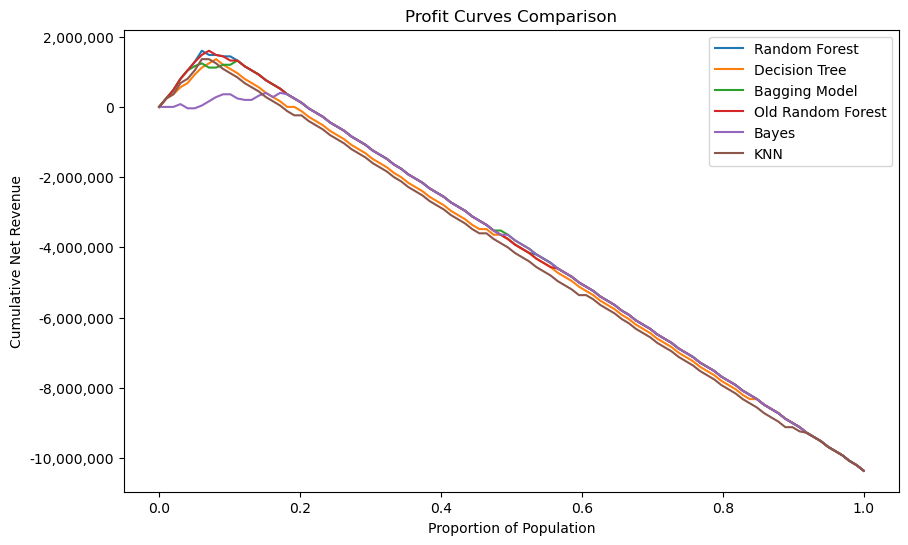

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import cross_val_predict

def plot_profit_curve(model, X, y, cost_matrix, n_points=100, ax=None, label=None):
    # Get predicted probabilities using cross-validation
    prob_pred = cross_val_predict(model, X, y, cv=10, method='predict_proba')

    # Prepare the data
    result = pd.DataFrame({'true': y, 'predicted_probabilities': prob_pred[:, 1]})
    sort = result.sort_values('predicted_probabilities', ascending=False)

    thresh_rang = np.linspace(0, 1, n_points)
    profits = []

    # Calculate profits for each threshold
    for i in thresh_rang:
        subset = sort.head(int(len(sort) * i))
        TP = (subset['true'] == 1).sum()
        FP = len(subset) - TP
        profit = TP * cost_matrix[0] + FP * cost_matrix[1]
        profits.append(profit)

    # Plotting
    if ax is None:
        ax = plt.gca()
    ax.plot(thresh_rang, profits, label=label)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define cost matrix
cost_matrix = np.array([80000, -40000])

# Assuming X_training, y_training are defined and models are already fitted
# Plot profit curves for each model
plot_profit_curve(randomforest, X_training, y_training, cost_matrix, ax=ax, label='Random Forest')
plot_profit_curve(decisions, X_training, y_training, cost_matrix, ax=ax, label='Decision Tree')
plot_profit_curve(bagging_model, X_training, y_training, cost_matrix, ax=ax, label='Bagging Model')
plot_profit_curve(randomforestog, X_training, y_training, cost_matrix, ax=ax, label='Old Random Forest')
plot_profit_curve(bayes, X_training, y_training, cost_matrix, ax=ax, label='Bayes')
plot_profit_curve(knn, X_training, y_training, cost_matrix, ax=ax, label='KNN')

# Set y-axis to display full integers
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Finalizing the plot
ax.set_xlabel('Proportion of Population')
ax.set_ylabel('Cumulative Net Revenue')
ax.legend()
ax.set_title('Profit Curves Comparison')
plt.show()


        My random forest model is the best one to use because out of all the revenue shown in all the charts, my random forest has the highest $ amount.

**3.4: Using the model selected in 3.3, formulate clearly the investment strategy you will use to decide which players to invest in. The strategy should include the following:**

  **a. Which model to use (along with corresponding parameters, such as number and type of models in bagging ensemble, number of K nearest neighbors, etc.)**

  **b. Given your model’s estimated probability of induction, above what probability threshold to invest in a player’s memorabilia.**



In [18]:
prob_predictions = cross_val_predict(randomforest, X_train, y_train, cv=10, method='predict_proba')

prob_df = pd.DataFrame({
    'Actual Class': y_train.reset_index(drop=True),  # Reset index to avoid indexing issues
    'prob': [round(pred[1], 4) for pred in prob_predictions]  # Probability of the positive class
})

# Sorting DataFrame by probabilities in descending order
prob_df = prob_df.sort_values("prob", ascending=False)

# Initialize a dictionary to store profits for each threshold
profit_dt = {}

# Iterate over each unique threshold to calculate profits
for threshold in prob_df['prob'].unique():
    targeted = prob_df[prob_df['prob'] >= threshold]
    TP = targeted['Actual Class'].sum()
    FP = len(targeted) - TP
    profit = TP * 80000 - FP * 40000  # Adjusted loss value to match your details
    profit_dt[threshold] = profit

# Identifying the optimal threshold for maximum profit
optimal_threshold = max(profit_dt, key=profit_dt.get)

# Display results
print(f"Optimal Threshold: {optimal_threshold}, Maximum Profit: ${profit_dt[optimal_threshold]}")

Optimal Threshold: 0.365, Maximum Profit: $1640000


        A. We used RandomForest as our model of choice with the following parameters from our grid search: max_depth= None, min_samples_leaf= 4, min_samples_split = 2, n_estimators = 10, random_state = 3.
                We also used the following features we received from using the wrapper method: 'defReb', 'reb', 'stl', 'turnover', 'fgm', 'ftm', 'firstSeason', 'yrsRetired2004', 'league_A', 'Position_C', 'Position_F', 'Position_G', 'Assists Per Minute', 'Points Per Minute', 'Rebounds Per Minute'.
                We created the per minute basis attributes with feature engineering

        B. The probability threshold is .365 for our model.

**3.5: Using `predict_proba`, predict probabilites for `class` with your best model on the testing data. Then, select which players to invest in based on the optimal probability threshold, display the list of players (along with their example number) in descending probability order, and report your profit.**

In [19]:
# Apply the optimal threshold to the testing data
y_prob_test = randomforest.predict_proba(X_test)[:, 1]
investment_decisions_test = y_prob_test >= .365

# Create a DataFrame for display and analysis, including the actual class
selected_players_test = pd.DataFrame({
    'Example Number': X_test.index,
    'Probability': y_prob_test,
    'Invest': investment_decisions_test,
    'Actual Class': y_test  # Add the actual class from the test set
}).sort_values(by='Probability', ascending=False)

selected_players_test = selected_players_test[selected_players_test['Invest'] == True]

n_selected_players = len(selected_players_test)
n_true_positives = sum(selected_players_test["Actual Class"])
n_false_positives = n_selected_players - n_true_positives
profit = n_true_positives * 80000 - n_false_positives * 20000

print(selected_players_test)
print("Profit associated with selected players: ${}".format(profit))

     Example Number  Probability  Invest  Actual Class
228             228        0.950    True          True
114             114        0.940    True          True
353             353        0.910    True          True
73               73        0.875    True          True
87               87        0.845    True          True
347             347        0.845    True          True
204             204        0.785    True          True
14               14        0.745    True          True
397             397        0.695    True          True
209             209        0.695    True          True
394             394        0.680    True          True
80               80        0.535    True          True
287             287        0.490    True          True
175             175        0.490    True          True
24               24        0.430    True         False
340             340        0.430    True          True
415             415        0.390    True         False
112       